## Extension of the 5% pool for all tracers

In [1]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg
import scipy.stats 

import matplotlib.gridspec as gspec

import warnings
warnings.filterwarnings("ignore")

/home/kramosmu/anaconda3/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
sns.set_context('notebook')
sns.set_style('white')

In [3]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/BARKLEY_II/run01/gridGlob.nc'

grid_fileNoC = '/data/kramosmu/results/TracerExperiments/BARKLEY_II/run02/gridGlob.nc'

state_file = '/data/kramosmu/results/TracerExperiments/BARKLEY_II/run01/stateGlob.nc' 

ptracers_file = '/data/kramosmu/results/TracerExperiments/BARKLEY_II/run01/ptracersGlob.nc'

ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/BARKLEY_II/run02/ptracersGlob.nc'

In [4]:
with Dataset(grid_file, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
    hFacC = nbl.variables['HFacC'][:]
    rA = nbl.variables['rA'][:]
    Depth = nbl.variables['Depth'][:]

hfac = np.ma.masked_values(hFacC, 0)
maskC = np.ma.getmask(hfac)

with Dataset(grid_fileNoC, 'r') as nbl:
    hFacCNoC = nbl.variables['HFacC'][:]

hfac = np.ma.masked_values(hFacCNoC, 0)
maskCNoC = np.ma.getmask(hfac)
 

with Dataset(state_file, 'r') as nbl:
    iters = nbl.variables['iter'][:]
 

In [5]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcAreaPool(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            if TrBottom > 0.0:
                ConcArea[i,j] = TrBottom*ra[i,j]
                Conc[i,j] = TrBottom
                Area[i,j] = ra[i,j]
            else:
                ConcArea[i,j] = np.NaN
                Conc[i,j] = np.NaN
                Area[i,j] = np.NaN
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def BottomConc(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotPool(ax,ConcFilt,xslice,yslice,value,col):
    
    #ax.axvline(X[xind_CS]/1000, color = '0.5', linestyle = '-', linewidth = 1)
    ax.axhline(Y[yind_AS]/1000, color = '0.7', linestyle = ':', linewidth = 1)
    
    BAC = ConcFilt[yslice,xslice]
    
    mesh = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[value], 
                      colors=col, 
                      )
    
    SB = ax.contour(X[xslice]/1000,Y[yslice]/1000,
                    Depth[yslice,xslice],
                    [150.0],
                    colors='0.1',linewidths=[0.75] )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    
    
def PlotAS(ax,Conc,xsl,zsl,value,col):
    print(np.shape(X[xsl]/1000),np.shape(Z[zsl]), np.shape(Conc))
   
    mesh = ax.contour(X[xsl]/1000,Z[zsl],Conc,[value], 
                      colors=col, 
                      )
    
    ax.plot(X[xsl]/1000,-Depth[yind_AS,xsl],
           '-',
           color='0.3',
           linewidth=5,
           )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    
def PlotCS(ax,Conc,yslice,zslice,value,col):
    
    mesh = ax.contour(Y[yslice]/1000,Z[zslice],Conc,[value], 
                      colors=col, 
                      )
    
    ax.plot(Y[yslice]/1000,-Depth[yslice_CS, xind_CS],
           '-',
           color='0.5',
           linewidth=2,
           )
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
        
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)

In [6]:
# General input
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
yind_AS = 275
xind_CS = 260

xslice_AS = slice(120,500)
yslice_CS = slice(227,360)
zslice_AS = slice(0,30)

yslice = slice(225,360)
xslice = slice(120,500)

tracer_names = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08', 'Tr09', 'Tr10']
colours = ['dark lavender','ocean blue','kelly green','cherry red',
           'tangerine','golden yellow','medium pink','turquoise', 'tan', 'olive']


In [7]:
ConcFilt1 = np.ma.empty((360,616)) 
ConcFilt2 = np.ma.empty((360,616))
ConcFilt3 = np.ma.empty((360,616))
ConcFilt4 = np.ma.empty((360,616))
ConcFilt5 = np.ma.empty((360,616))
ConcFilt6 = np.ma.empty((360,616))
ConcFilt7 = np.ma.empty((360,616))
ConcFilt8 = np.ma.empty((360,616))
ConcFilt9 = np.ma.empty((360,616))
ConcFilt10 = np.ma.empty((360,616))

ConcAS1 = np.ma.empty((30,len(X[xslice_AS]))) 
ConcAS2 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS3 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS4 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS5 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS6 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS7 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS8 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS9 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS10 = np.ma.empty((30,len(X[xslice_AS])))

ConcCS1 = np.ma.empty((30,len(Y[yslice_CS]))) 
ConcCS2 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS3 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS4 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS5 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS6 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS7 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS8 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS9 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS10 = np.ma.empty((30,len(Y[yslice_CS])))

concList = [ConcFilt1,ConcFilt2,ConcFilt3,ConcFilt4,ConcFilt5,ConcFilt6,ConcFilt7,ConcFilt8,ConcFilt9,ConcFilt10]
concASList = [ConcAS1,ConcAS2,ConcAS3,ConcAS4,ConcAS5,ConcAS6,ConcAS7,ConcAS8,ConcAS9, ConcAS10]
concCSList = [ConcCS1,ConcCS2,ConcCS3,ConcCS4,ConcCS5,ConcCS6,ConcCS7,ConcCS8,ConcCS9, ConcCS10]

for trac,conc, concAS, concCS in zip(tracer_names, concList, concASList, concCSList):
    with Dataset(ptracers_file, 'r') as nbl:
        ConcArea, conc[:,:], Area = BottomConc(np.mean(nbl.variables[trac][8:18,:,:,:], axis=0),hFacC,rA,Depth)
        concAS[:,:] = np.ma.array(np.nanmean(nbl.variables[trac][8:18,zslice_AS,yind_AS,xslice_AS],0),
                                  mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
        concCS[:,:] = np.ma.array(np.nanmean(nbl.variables[trac][8:18,zslice_AS,yslice_CS,xind_CS],0),
                                  mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
    print('done with tracer %s' %trac )

done with tracer Tr01
done with tracer Tr02
done with tracer Tr03
done with tracer Tr04
done with tracer Tr05
done with tracer Tr06
done with tracer Tr07
done with tracer Tr08
done with tracer Tr09
done with tracer Tr10


In [8]:
Conc0Filt1 = np.ma.empty((360,616)) # saving 3 time outputs, ny,nx
Conc0Filt2 = np.ma.empty((360,616))
Conc0Filt3 = np.ma.empty((360,616))
Conc0Filt4 = np.ma.empty((360,616))
Conc0Filt5 = np.ma.empty((360,616))
Conc0Filt6 = np.ma.empty((360,616))
Conc0Filt7 = np.ma.empty((360,616))
Conc0Filt8 = np.ma.empty((360,616))
Conc0Filt9 = np.ma.empty((360,616))
Conc0Filt10 = np.ma.empty((360,616))

Conc0AS1 = np.ma.empty((30,len(X[xslice_AS]))) 
Conc0AS2 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS3 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS4 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS5 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS6 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS7 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS8 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS9 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS10 = np.ma.empty((30,len(X[xslice_AS])))

Conc0CS1 = np.ma.empty((30,len(Y[yslice_CS]))) 
Conc0CS2 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS3 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS4 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS5 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS6 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS7 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS8 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS9 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS10 = np.ma.empty((30,len(Y[yslice_CS])))

concList = [Conc0Filt1,Conc0Filt2,Conc0Filt3,Conc0Filt4,Conc0Filt5,Conc0Filt6,Conc0Filt7,Conc0Filt8,Conc0Filt9,Conc0Filt10]
concASList = [Conc0AS1,Conc0AS2,Conc0AS3,Conc0AS4,Conc0AS5,Conc0AS6,Conc0AS7,Conc0AS8,Conc0AS9,Conc0AS10]
concCSList = [Conc0CS1,Conc0CS2,Conc0CS3,Conc0CS4,Conc0CS5,Conc0CS6,Conc0CS7,Conc0CS8,Conc0CS9,Conc0CS10]

for trac,conc, concAS, concCS in zip(tracer_names, concList, concASList, concCSList):
    with Dataset(ptracers_file, 'r') as nbl:
        ConcArea, conc[:,:], Area = BottomConc(nbl.variables[trac][0,:,:,:],hFacC,rA,Depth)
        concAS[:,:] = np.ma.array(nbl.variables[trac][0,zslice_AS,yind_AS,xslice_AS],
                                  mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
        concCS[:,:] = np.ma.array(nbl.variables[trac][0,zslice_AS,yslice_CS,xind_CS],
                                  mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
    print('done with tracer %s' %trac )

done with tracer Tr01
done with tracer Tr02
done with tracer Tr03
done with tracer Tr04
done with tracer Tr05
done with tracer Tr06
done with tracer Tr07
done with tracer Tr08
done with tracer Tr09
done with tracer Tr10


In [9]:
ConcFilt1Anom = np.ma.empty((360,616)) # saving 3 time outputs, nx,ny
ConcFilt2Anom = np.ma.empty((360,616))
ConcFilt3Anom = np.ma.empty((360,616))
ConcFilt4Anom = np.ma.empty((360,616))
ConcFilt5Anom = np.ma.empty((360,616))
ConcFilt6Anom = np.ma.empty((360,616))
ConcFilt7Anom = np.ma.empty((360,616))
ConcFilt8Anom = np.ma.empty((360,616))
ConcFilt9Anom = np.ma.empty((360,616))
ConcFilt10Anom = np.ma.empty((360,616))

ConcAS1Anom = np.ma.empty((30,len(X[xslice_AS]))) 
ConcAS2Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS3Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS4Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS5Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS6Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS7Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS8Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS9Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS10Anom = np.ma.empty((30,len(X[xslice_AS])))

ConcCS1Anom = np.ma.empty((30,len(Y[yslice_CS]))) 
ConcCS2Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS3Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS4Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS5Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS6Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS7Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS8Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS9Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS10Anom = np.ma.empty((30,len(Y[yslice_CS])))

concList = [ConcFilt1Anom,ConcFilt2Anom,ConcFilt3Anom,ConcFilt4Anom,
            ConcFilt5Anom,ConcFilt6Anom,ConcFilt7Anom,ConcFilt8Anom,ConcFilt9Anom,ConcFilt10Anom]
concASList = [ConcAS1Anom,ConcAS2Anom,ConcAS3Anom,ConcAS4Anom,ConcAS5Anom,
              ConcAS6Anom,ConcAS7Anom,ConcAS8Anom,ConcAS9Anom,ConcAS10Anom]
concCSList = [ConcCS1Anom,ConcCS2Anom,ConcCS3Anom,ConcCS4Anom,ConcCS5Anom,
              ConcCS6Anom,ConcCS7Anom,ConcCS8Anom,ConcCS9Anom,ConcCS10Anom]


for trac,conc, concAS, concCS in zip(tracer_names, concList, concASList, concCSList):
    with Dataset(ptracers_file, 'r') as nbl:
        with Dataset(ptracers_fileNoC, 'r') as noc:
            ConcArea, conc[:,:], Area = BottomConc(np.nanmean(nbl.variables[trac][8:18,:,:,:]-
                                                              noc.variables[trac][8:18,:,:,:],axis=0),hFacC,rA,Depth)
            concAS[:,:] = np.ma.array(np.nanmean(nbl.variables[trac][8:18,zslice_AS,yind_AS,xslice_AS]-
                                                 noc.variables[trac][8:18,zslice_AS,yind_AS,xslice_AS],0),
                                      mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
            concCS[:,:] = np.ma.array(np.nanmean(nbl.variables[trac][8:18,zslice_AS,yslice_CS,xind_CS]-
                                                 noc.variables[trac][8:18,zslice_AS,yslice_CS,xind_CS],0),
                                      mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
       
    print('done with tracer %s' %trac )

done with tracer Tr01
done with tracer Tr02
done with tracer Tr03
done with tracer Tr04
done with tracer Tr05
done with tracer Tr06
done with tracer Tr07
done with tracer Tr08
done with tracer Tr09
done with tracer Tr10


(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)


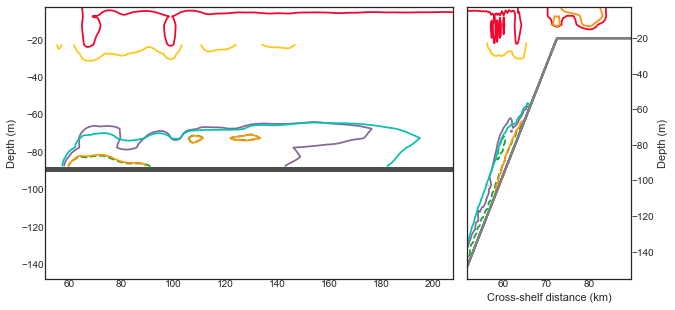

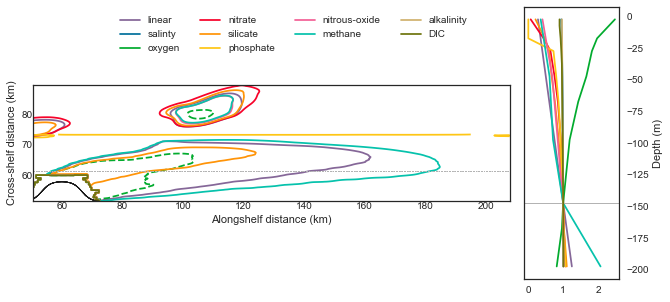

In [10]:
f = plt.figure(figsize = (10.5,5.0)) # 19.0cm = 7.4in, 115cm = 4.52in

gs = gspec.GridSpec(1, 2, width_ratios=[1,0.4], wspace=0.05, hspace=0.05 )

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

f1 = plt.figure(figsize = (10.5,5.0)) # 19.0cm = 7.4in, 115cm = 4.52in

gs2 = gspec.GridSpec(1, 2,  width_ratios=[1,0.2], wspace=0.05, hspace=0.05 )

ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1])

CONT = 0.1

ii = 0    

PlotPool(ax2,(ConcFilt1Anom[:,:])/Conc0Filt1,xslice,yslice,CONT,col=sns.xkcd_rgb[colours[0]])
PlotPool(ax2,(ConcFilt2Anom[:,:])/Conc0Filt2,xslice,yslice,CONT,col=sns.xkcd_rgb[colours[1]])
PlotPool(ax2,(ConcFilt3Anom[:,:])/Conc0Filt3,xslice,yslice,-CONT,col=sns.xkcd_rgb[colours[2]])
PlotPool(ax2,(ConcFilt4Anom[:,:])/Conc0Filt4,xslice,yslice,CONT,col=sns.xkcd_rgb[colours[3]])
PlotPool(ax2,(ConcFilt5Anom[:,:])/Conc0Filt5,xslice,yslice,CONT,col=sns.xkcd_rgb[colours[4]])
PlotPool(ax2,(ConcFilt6Anom[:,:])/Conc0Filt6,xslice,yslice,CONT,col=sns.xkcd_rgb[colours[5]])
PlotPool(ax2,(ConcFilt7Anom[:,:])/Conc0Filt7,xslice,yslice,CONT,col=sns.xkcd_rgb[colours[6]])
PlotPool(ax2,(ConcFilt8Anom[:,:])/Conc0Filt8,xslice,yslice,CONT,col=sns.xkcd_rgb[colours[7]])
PlotPool(ax2,(ConcFilt9Anom[:,:])/Conc0Filt9,xslice,yslice,CONT,col=sns.xkcd_rgb[colours[8]])
PlotPool(ax2,(ConcFilt10Anom[:,:])/Conc0Filt10,xslice,yslice,CONT,col=sns.xkcd_rgb[colours[9]])

PlotAS(ax0,(ConcAS1Anom[:,:]/Conc0AS1),xslice_AS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[0]])
PlotAS(ax0,(ConcAS2Anom[:,:]/Conc0AS2),xslice_AS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[1]])
PlotAS(ax0,(ConcAS3Anom[:,:]/Conc0AS3),xslice_AS,zslice_AS,-CONT,col=sns.xkcd_rgb[colours[2]])
PlotAS(ax0,(ConcAS4Anom[:,:]/Conc0AS4),xslice_AS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[3]])
PlotAS(ax0,(ConcAS5Anom[:,:]/Conc0AS5),xslice_AS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[4]])
PlotAS(ax0,(ConcAS6Anom[:,:]/Conc0AS6),xslice_AS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[5]])
PlotAS(ax0,(ConcAS7Anom[:,:]/Conc0AS7),xslice_AS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[6]])
PlotAS(ax0,(ConcAS8Anom[:,:]/Conc0AS8),xslice_AS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[7]])
PlotAS(ax0,(ConcAS9Anom[:,:]/Conc0AS9),xslice_AS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[8]])
PlotAS(ax0,(ConcAS10Anom[:,:]/Conc0AS10),xslice_AS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[9]])
 
PlotCS(ax1,(ConcCS1Anom[:,:]/Conc0CS1[:,:]),yslice_CS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[0]])
PlotCS(ax1,(ConcCS2Anom[:,:]/Conc0CS2[:,:]),yslice_CS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[1]])
PlotCS(ax1,(ConcCS3Anom[:,:]/Conc0CS3[:,:]),yslice_CS,zslice_AS,-CONT,col=sns.xkcd_rgb[colours[2]])
PlotCS(ax1,(ConcCS4Anom[:,:]/Conc0CS4[:,:]),yslice_CS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[3]])
PlotCS(ax1,(ConcCS5Anom[:,:]/Conc0CS5[:,:]),yslice_CS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[4]])
PlotCS(ax1,(ConcCS6Anom[:,:]/Conc0CS6[:,:]),yslice_CS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[5]])
PlotCS(ax1,(ConcCS7Anom[:,:]/Conc0CS7[:,:]),yslice_CS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[6]])
PlotCS(ax1,(ConcCS8Anom[:,:]/Conc0CS8[:,:]),yslice_CS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[7]])
PlotCS(ax1,(ConcCS9Anom[:,:]/Conc0CS9[:,:]),yslice_CS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[8]])
PlotCS(ax1,(ConcCS10Anom[:,:]/Conc0CS10[:,:]),yslice_CS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[9]])

tracer_legend = ['linear','salinty','oxygen','nitrate','silicate',
                 'phosphate','nitrous-oxide','methane', 'alkalinity','DIC']
with Dataset(ptracers_file, 'r') as nbl:
    for trac, ii, lab in zip(tracer_names, range(len(tracer_names)), tracer_legend):
        ax3.axhline(Z[29], color='0.7', linewidth=1)
        profile = nbl.variables[trac][0,0:40,50,180]
        C0 = profile[29]
        ax3.plot(profile/C0,Z[0:40],color=sns.xkcd_rgb[colours[ii]], label=lab)
        ax3.yaxis.tick_right()
        ax3.yaxis.set_label_position("right")
        ax3.set_ylabel('Depth (m)')

ax0.set_ylabel('Depth (m)')
ax2.set_xlabel('Alongshelf distance (km)')
ax2.set_ylabel('Cross-shelf distance (km)')
ax1.set_xlabel('Cross-shelf distance (km)')
ax1.set_ylabel('Depth (m)')

ax3.legend(ncol=4, bbox_to_anchor=(-0.5,1) )


(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)


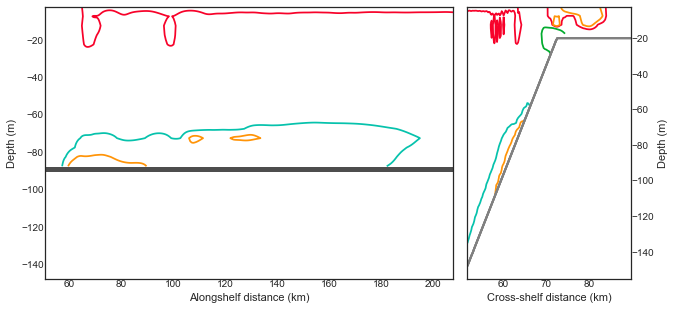

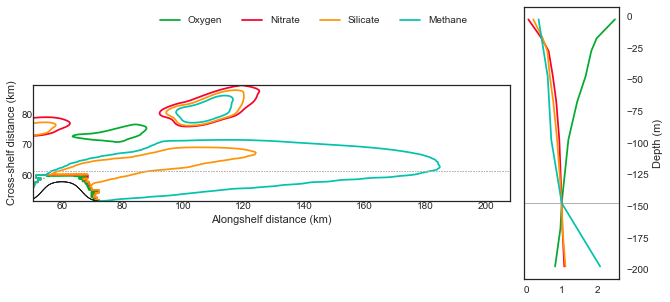

In [11]:
f1 = plt.figure(figsize = (10.5,5)) # 19.0cm = 7.4in, 115cm = 4.52in

gs = gspec.GridSpec(1, 2, width_ratios=[1,0.4], wspace=0.05, hspace=0.05 )

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

f1 = plt.figure(figsize = (10.5,5.0)) # 19.0cm = 7.4in, 115cm = 4.52in

gs2 = gspec.GridSpec(1, 2,  width_ratios=[1,0.2], wspace=0.05, hspace=0.05 )

ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1])
CONT=0.1
ii = 0    

PlotPool(ax2,(ConcFilt3Anom[:,:])/Conc0Filt3,xslice,yslice,CONT,col=sns.xkcd_rgb[colours[2]])
PlotPool(ax2,(ConcFilt4Anom[:,:])/Conc0Filt4,xslice,yslice,CONT,col=sns.xkcd_rgb[colours[3]])
PlotPool(ax2,(ConcFilt5Anom[:,:])/Conc0Filt5,xslice,yslice,CONT,col=sns.xkcd_rgb[colours[4]])
PlotPool(ax2,(ConcFilt8Anom[:,:])/Conc0Filt8,xslice,yslice,CONT,col=sns.xkcd_rgb[colours[7]])

PlotAS(ax0,(ConcAS3Anom[:,:]/Conc0AS3),xslice_AS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[2]])
PlotAS(ax0,(ConcAS4Anom[:,:]/Conc0AS4),xslice_AS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[3]])
PlotAS(ax0,(ConcAS5Anom[:,:]/Conc0AS5),xslice_AS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[4]])
PlotAS(ax0,(ConcAS8Anom[:,:]/Conc0AS8),xslice_AS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[7]])
 
PlotCS(ax1,(ConcCS3Anom[:,:]/Conc0CS3[:,:]),yslice_CS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[2]])
PlotCS(ax1,(ConcCS4Anom[:,:]/Conc0CS4[:,:]),yslice_CS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[3]])
PlotCS(ax1,(ConcCS5Anom[:,:]/Conc0CS5[:,:]),yslice_CS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[4]])
PlotCS(ax1,(ConcCS8Anom[:,:]/Conc0CS8[:,:]),yslice_CS,zslice_AS,CONT,col=sns.xkcd_rgb[colours[7]])

tracer_names_2 = ['Tr03', 'Tr04', 'Tr05', 'Tr08']
tracer_legend_2 = ['Oxygen','Nitrate','Silicate','Methane']

with Dataset(ptracers_file, 'r') as nbl:
    for trac, ii, lab in zip(tracer_names_2, [2,3,4,7], tracer_legend_2):
        ax3.axhline(Z[29], color='0.7', linewidth=1)
        profile = nbl.variables[trac][0,0:40,50,180]
        C0 = profile[29]
        ax3.plot(profile/C0,Z[0:40],color=sns.xkcd_rgb[colours[ii]], label=lab)
        ax3.yaxis.tick_right()
        ax3.yaxis.set_label_position("right")
        ax3.set_ylabel('Depth (m)')

ax0.set_ylabel('Depth (m)')
ax2.set_xlabel('Alongshelf distance (km)')
ax0.set_xlabel('Alongshelf distance (km)')

ax2.set_ylabel('Cross-shelf distance (km)')
ax1.set_xlabel('Cross-shelf distance (km)')
ax1.set_ylabel('Depth (m)')

ax3.legend(ncol=4, bbox_to_anchor=(-0.5,1) )



(380,) (10,) (10, 380)
(380,) (10,) (10, 380)
(380,) (10,) (10, 380)
(380,) (10,) (10, 380)


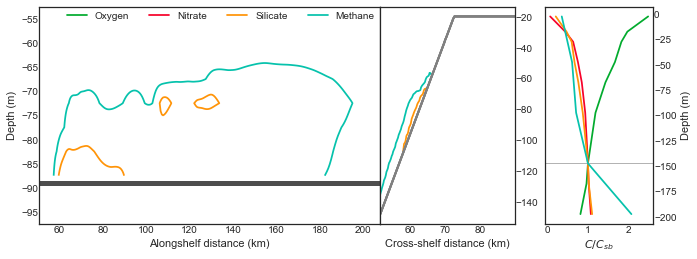

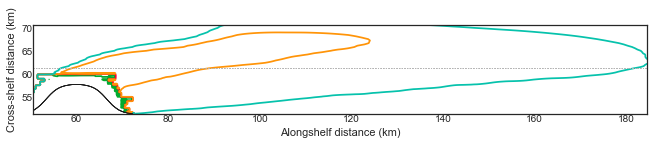

In [12]:
yslice2 = slice(225,310)
xslice2 = slice(120,463)
zslice_AS2 = slice(10,20)
zslice_CS2 = slice(10,30)

f1 = plt.figure(figsize = (11,4)) # 19.0cm = 7.4in, 115cm = 4.52in

gs = gspec.GridSpec(1, 2, width_ratios=[1, 0.8], wspace=0.0, hspace=0.05 )
gs0 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1],width_ratios=[1,0.8], wspace=0.25)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs0[0])
ax3 = plt.subplot(gs0[1])

f2, ax2 = plt.subplots(1,1,figsize = (11,4.0)) # 19.0cm = 7.4in, 115cm = 4.52in

ii = 0    

PlotPool(ax2,(ConcFilt3Anom[:,:])/Conc0Filt3,xslice2,yslice2,CONT,col=sns.xkcd_rgb[colours[2]])
PlotPool(ax2,(ConcFilt4Anom[:,:])/Conc0Filt4,xslice2,yslice2,CONT,col=sns.xkcd_rgb[colours[3]])
PlotPool(ax2,(ConcFilt5Anom[:,:])/Conc0Filt5,xslice2,yslice2,CONT,col=sns.xkcd_rgb[colours[4]])
PlotPool(ax2,(ConcFilt8Anom[:,:])/Conc0Filt8,xslice2,yslice2,CONT,col=sns.xkcd_rgb[colours[7]])

PlotAS(ax0,(ConcAS3Anom[zslice_AS2, :]/Conc0AS3[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT,col=sns.xkcd_rgb[colours[2]])
PlotAS(ax0,(ConcAS4Anom[zslice_AS2, :]/Conc0AS4[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT,col=sns.xkcd_rgb[colours[3]])
PlotAS(ax0,(ConcAS5Anom[zslice_AS2, :]/Conc0AS5[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT,col=sns.xkcd_rgb[colours[4]])
PlotAS(ax0,(ConcAS8Anom[zslice_AS2, :]/Conc0AS8[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT,col=sns.xkcd_rgb[colours[7]])
 
PlotCS(ax1,(ConcCS3Anom[zslice_CS2,:]/Conc0CS3[zslice_CS2,:]),yslice_CS,zslice_CS2,CONT,col=sns.xkcd_rgb[colours[2]])
PlotCS(ax1,(ConcCS4Anom[zslice_CS2,:]/Conc0CS4[zslice_CS2,:]),yslice_CS,zslice_CS2,CONT,col=sns.xkcd_rgb[colours[3]])
PlotCS(ax1,(ConcCS5Anom[zslice_CS2,:]/Conc0CS5[zslice_CS2,:]),yslice_CS,zslice_CS2,CONT,col=sns.xkcd_rgb[colours[4]])
PlotCS(ax1,(ConcCS8Anom[zslice_CS2,:]/Conc0CS8[zslice_CS2,:]),yslice_CS,zslice_CS2,CONT,col=sns.xkcd_rgb[colours[7]])

tracer_names_2 = ['Tr03', 'Tr04', 'Tr05', 'Tr08']
tracer_legend_2 = ['Oxygen','Nitrate','Silicate','Methane']

with Dataset(ptracers_file, 'r') as nbl:
    for trac, ii, lab in zip(tracer_names_2, [2,3,4,7], tracer_legend_2):
        ax3.axhline(Z[29], color='0.7', linewidth=1)
        profile = nbl.variables[trac][0,0:40,50,180]
        C0 = profile[29]
        ax3.plot(profile/C0,Z[0:40],color=sns.xkcd_rgb[colours[ii]], label=lab)
        ax3.yaxis.tick_right()
        ax3.yaxis.set_label_position("right")
        ax3.set_ylabel('Depth (m)')

ax3.tick_params(axis='x', pad=1)
ax3.tick_params(axis='y', pad=1)

ax3.set_xlabel('$C/C_{sb}$')
ax0.set_ylabel('Depth (m)')
ax2.set_xlabel('Alongshelf distance (km)')
ax0.set_xlabel('Alongshelf distance (km)')

ax2.set_ylabel('Cross-shelf distance (km)')
ax1.set_xlabel('Cross-shelf distance (km)')
#ax1.set_ylabel('Depth (m)')

ax3.legend(ncol=4, bbox_to_anchor=(-1.5,1.02) )

f1.savefig('pool_vert_10percent_O2NitSilMet.eps', format='eps',bbox_inches='tight')
f2.savefig('pool_10percent_O2NitSilMet.eps', format='eps',bbox_inches='tight')


## Bottom concentrations

In [13]:
BCA01 = np.ma.empty((nt,ny,nx))
BCA02 = np.ma.empty((nt,ny,nx))
BCA03 = np.ma.empty((nt,ny,nx))
BCA04 = np.ma.empty((nt,ny,nx))
BCA05 = np.ma.empty((nt,ny,nx))
BCA06 = np.ma.empty((nt,ny,nx))
BCA07 = np.ma.empty((nt,ny,nx))
BCA08 = np.ma.empty((nt,ny,nx))
BCA09 = np.ma.empty((nt,ny,nx))
BCA10 = np.ma.empty((nt,ny,nx))

BC01 = np.ma.empty((nt,ny,nx))
BC02 = np.ma.empty((nt,ny,nx))
BC03 = np.ma.empty((nt,ny,nx))
BC04 = np.ma.empty((nt,ny,nx))
BC05 = np.ma.empty((nt,ny,nx))
BC06 = np.ma.empty((nt,ny,nx))
BC07 = np.ma.empty((nt,ny,nx))
BC08 = np.ma.empty((nt,ny,nx))
BC09 = np.ma.empty((nt,ny,nx))
BC10 = np.ma.empty((nt,ny,nx))

Area01 = np.ma.empty((nt,ny,nx))
Area02 = np.ma.empty((nt,ny,nx))
Area03 = np.ma.empty((nt,ny,nx))
Area04 = np.ma.empty((nt,ny,nx))
Area05 = np.ma.empty((nt,ny,nx))
Area06 = np.ma.empty((nt,ny,nx))
Area07 = np.ma.empty((nt,ny,nx))
Area08 = np.ma.empty((nt,ny,nx))
Area09 = np.ma.empty((nt,ny,nx))
Area10 = np.ma.empty((nt,ny,nx))

concList = [BC01,BC02,BC03,BC04,BC05,BC06,BC07,BC08,BC09,BC10]
concListAnom = [BCA01,BCA02,BCA03,BCA04,BCA05,BCA06,BCA07,BCA08,BCA09, BCA10]
areaList = [Area01,Area02,Area03,Area04,Area05,Area06,Area07,Area08,Area09,Area10]

for trac,BC,BCA,Area in zip(tracer_names, concList, concListAnom, areaList):
    with Dataset(ptracers_file, 'r') as nbl:
        with Dataset(ptracers_fileNoC, 'r') as noc:
            for ii in range(nt):
                BCA[ii,:,:], dummy, AreaTot1 = BottomConc(noc.variables[trac][ii,:,:,:], hFacCNoC,rA,Depth)
                BC[ii,:,:], dummy, AreaTot2 = BottomConc(nbl.variables[trac][ii,:,:,:],hFacCNoC,rA,Depth)


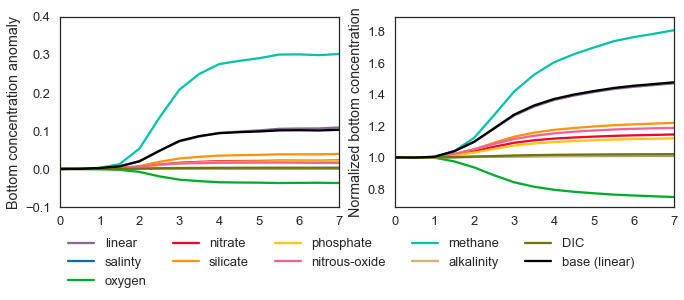

In [14]:
sns.set_context('talk')
tracer_names_2 = ['Tr03', 'Tr04', 'Tr05', 'Tr08']
tracer_legend_2 = ['Oxygen','Nitrate','Silicate','Methane']

fig, (ax1,ax3) = plt.subplots(1,2,figsize=(11,3.5))

ax1.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC01[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC01[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA01[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA01[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[0]], label=tracer_legend[0])

ax1.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC02[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC02[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA02[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA02[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[1]], label=tracer_legend[1])

ax1.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC03[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC03[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA03[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA03[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[2]], label=tracer_legend[2])

ax1.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC04[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC04[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA04[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA04[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[3]], label=tracer_legend[3])

ax1.plot(np.arange(19)/2,((np.nansum(np.nansum(BC05[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC05[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA05[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA05[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[4]], label=tracer_legend[4])

ax1.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC06[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC06[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA06[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA06[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[5]], label=tracer_legend[5])

ax1.plot(np.arange(19)/2,  ((np.nansum(np.nansum(BC07[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC07[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA07[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA07[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[6]], label=tracer_legend[6])

ax1.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC08[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC08[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA08[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA08[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[7]], label=tracer_legend[7])

ax1.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC09[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC09[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA09[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA09[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[8]], label=tracer_legend[8])

ax1.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC10[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC10[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA10[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA10[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[9]], label=tracer_legend[9])

#ax2.plot(np.arange(19)/2, np.nansum(np.nansum(Area01[:,227:310,120:463], axis=1), axis=1), color=sns.xkcd_rgb[colours[0]])
#ax2.plot(np.arange(19)/2, np.nansum(np.nansum(Area02[:,227:310,120:463], axis=1), axis=1), color=sns.xkcd_rgb[colours[1]])
#ax2.plot(np.arange(19)/2, np.nansum(np.nansum(Area03[:,227:310,120:463], axis=1), axis=1), color=sns.xkcd_rgb[colours[2]])
#ax2.plot(np.arange(19)/2, np.nansum(np.nansum(Area04[:,227:310,120:463], axis=1), axis=1), color=sns.xkcd_rgb[colours[3]])
#ax2.plot(np.arange(19)/2, np.nansum(np.nansum(Area05[:,227:310,120:463], axis=1), axis=1), color=sns.xkcd_rgb[colours[4]])
#ax2.plot(np.arange(19)/2, np.nansum(np.nansum(Area06[:,227:310,120:463], axis=1), axis=1), color=sns.xkcd_rgb[colours[5]])
#ax2.plot(np.arange(19)/2, np.nansum(np.nansum(Area07[:,227:310,120:463], axis=1), axis=1), color=sns.xkcd_rgb[colours[6]])
#ax2.plot(np.arange(19)/2, np.nansum(np.nansum(Area08[:,227:310,120:463], axis=1), axis=1), color=sns.xkcd_rgb[colours[7]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC01[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC01[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[0]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC02[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC02[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[1]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC03[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC03[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[2]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC04[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC04[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[3]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC05[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC05[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[4]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC06[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC06[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[5]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC07[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC07[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[6]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC08[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC08[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[7]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC09[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC09[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[8]])

ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(BC10[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC10[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463])))),
         color=sns.xkcd_rgb[colours[9]])

base_bca = [ -1.11022302e-16,   3.27748089e-04,   2.49571927e-03,   6.85099066e-03,
            2.01412968e-02 ,  4.74174012e-02,   7.36570269e-02,   8.63883064e-02,
            9.40174992e-02 ,  9.66160816e-02,   9.84813510e-02,   1.01316487e-01,
            1.01786341e-01 ,  1.01116764e-01,   1.02827644e-01,   1.03010812e-01,
            1.02135944e-01 ,  1.00841532e-01,   9.94211389e-02]
base_bott = [ 1. ,         0.9986724,   1.00389353 , 1.03979195,  1.1002109,   1.18557154,
             1.27196462 , 1.33026175 , 1.37127231 , 1.39955091 , 1.42181862,  1.4412679,
             1.45550199 , 1.46619827 , 1.47715422 , 1.48471718 , 1.48972171,  1.49316467,
             1.49557212]

ax1.plot(np.arange(19)/2, base_bca,
         color=sns.xkcd_rgb['black'], label='base (linear)')

ax3.plot(np.arange(19)/2, base_bott,
         color=sns.xkcd_rgb['black'])


ax1.set_xlim(0,7)
#ax2.set_xlim(0,7)
ax3.set_xlim(0,7)

ax1.set_ylim(-0.1, 0.4)
ax1.legend(bbox_to_anchor=(2.1, -0.1), ncol=5)
ax3.set_ylabel('Normalized bottom concentration')
ax1.set_ylabel('Bottom concentration anomaly')
#ax2.set_ylabel('Area ( $10^9$ m$^2$)')
fig.savefig('bottom_conc_BARKLEY_II.eps', format='eps',bbox_inches='tight')



(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)


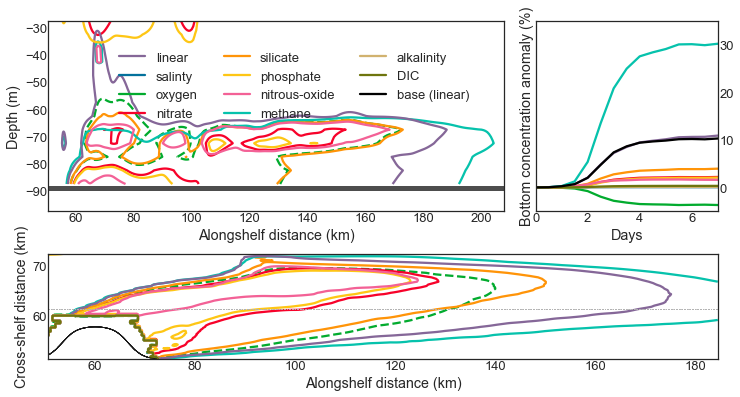

In [15]:
f1 = plt.figure(figsize = (12,7)) # 19.0cm = 7.4in, 115cm = 4.52in

gs0 = gspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.0)
gs01 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0],width_ratios=[1,0.4], wspace=0.1)
    
ax2 = plt.subplot(gs0[1])
ax0 = plt.subplot(gs01[0])
ax1 = plt.subplot(gs01[1])

ii = 0    

yslice2 = slice(225,315)
xslice2 = slice(120,463)
zslice_AS2 = slice(5,20)
zslice_CS2 = slice(5,30)

CONT = 0.05
PlotPool(ax2,(ConcFilt3Anom[:,:])/Conc0Filt3,xslice2,yslice2,-CONT, col=sns.xkcd_rgb[colours[2]])
PlotPool(ax2,(ConcFilt4Anom[:,:])/Conc0Filt4,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[3]])
PlotPool(ax2,(ConcFilt5Anom[:,:])/Conc0Filt5,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[4]])
PlotPool(ax2,(ConcFilt8Anom[:,:])/Conc0Filt8,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[7]])

PlotPool(ax2,(ConcFilt1Anom[:,:])/Conc0Filt1,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[0]])
PlotPool(ax2,(ConcFilt2Anom[:,:])/Conc0Filt2,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[1]])
PlotPool(ax2,(ConcFilt6Anom[:,:])/Conc0Filt6,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[5]])
PlotPool(ax2,(ConcFilt7Anom[:,:])/Conc0Filt7,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[6]])
PlotPool(ax2,(ConcFilt9Anom[:,:])/Conc0Filt9,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[8]])
PlotPool(ax2,(ConcFilt10Anom[:,:])/Conc0Filt10,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[9]])

PlotAS(ax0,(ConcAS3Anom[zslice_AS2, :]/Conc0AS3[zslice_AS2, :]),xslice_AS,zslice_AS2,-CONT, col=sns.xkcd_rgb[colours[2]])
PlotAS(ax0,(ConcAS4Anom[zslice_AS2, :]/Conc0AS4[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[3]])
PlotAS(ax0,(ConcAS5Anom[zslice_AS2, :]/Conc0AS5[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[4]])
PlotAS(ax0,(ConcAS8Anom[zslice_AS2, :]/Conc0AS8[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[7]])
PlotAS(ax0,(ConcAS9Anom[zslice_AS2, :]/Conc0AS9[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[8]])
PlotAS(ax0,(ConcAS10Anom[zslice_AS2, :]/Conc0AS10[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[9]])

PlotAS(ax0,(ConcAS1Anom[zslice_AS2, :]/Conc0AS1[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[0]])
PlotAS(ax0,(ConcAS2Anom[zslice_AS2, :]/Conc0AS2[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[1]])
PlotAS(ax0,(ConcAS6Anom[zslice_AS2, :]/Conc0AS6[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[5]])
PlotAS(ax0,(ConcAS7Anom[zslice_AS2, :]/Conc0AS7[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[6]])


ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(BC01[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC01[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA01[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA01[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[0]], label=tracer_legend[0])

ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(BC02[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC02[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA02[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA02[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[1]], label=tracer_legend[1])

ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(BC03[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC03[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA03[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA03[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[2]], label=tracer_legend[2])

ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(BC04[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC04[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA04[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA04[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[3]], label=tracer_legend[3])

ax1.plot(np.arange(19)/2,(((np.nansum(np.nansum(BC05[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC05[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA05[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA05[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[4]], label=tracer_legend[4])

ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(BC06[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC06[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA06[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA06[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[5]], label=tracer_legend[5])

ax1.plot(np.arange(19)/2,  (((np.nansum(np.nansum(BC07[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC07[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA07[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA07[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[6]], label=tracer_legend[6])

ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(BC08[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC08[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA08[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA08[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[7]], label=tracer_legend[7])

ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(BC09[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC09[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA09[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA09[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[8]], label=tracer_legend[8])

ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(BC10[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC10[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA10[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA10[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[9]], label=tracer_legend[9])


base_bca = np.array([ -1.11022302e-16,   3.27748089e-04,   2.49571927e-03,   6.85099066e-03,
            2.01412968e-02 ,  4.74174012e-02,   7.36570269e-02,   8.63883064e-02,
            9.40174992e-02 ,  9.66160816e-02,   9.84813510e-02,   1.01316487e-01,
            1.01786341e-01 ,  1.01116764e-01,   1.02827644e-01,   1.03010812e-01,
            1.02135944e-01 ,  1.00841532e-01,   9.94211389e-02])

ax1.plot(np.arange(19)/2, 100*base_bca,color=sns.xkcd_rgb['black'], label='base (linear)')


ax0.set_ylabel('Depth (m)')
ax0.set_xlabel('Alongshelf distance (km)')
ax2.set_xlabel('Alongshelf distance (km)')
ax2.set_ylabel('Cross-shelf distance (km)')
ax1.set_xlabel('Days')
ax1.set_ylabel('Bottom concentration anomaly (%)', labelpad=2)
ax1.yaxis.set_ticks_position("right")

ax1.set_xlim(0,7)
ax1.set_ylim(-5,35)

#
ax1.tick_params(axis='x', pad=1)
ax1.tick_params(axis='y', pad=1.5)
ax1.legend(ncol=3, bbox_to_anchor=(-0.3,0.9) )

f1.savefig('pool_5percent_O2NitSilMet.eps', format='eps',bbox_inches='tight')


(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)


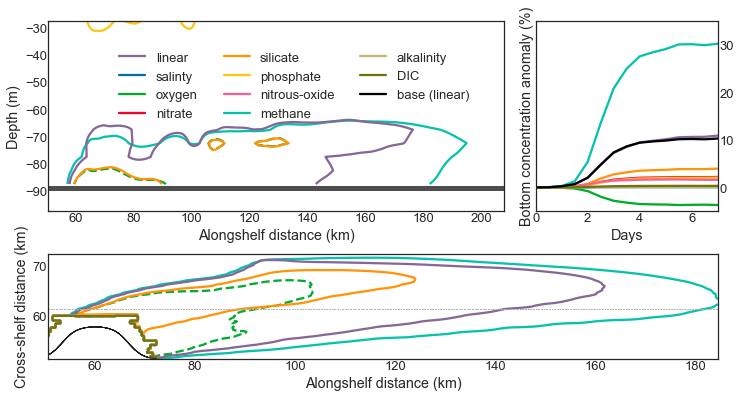

In [16]:
f1 = plt.figure(figsize = (12,7)) # 19.0cm = 7.4in, 115cm = 4.52in

CONT = 0.1
gs0 = gspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.0)
gs01 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0],width_ratios=[1,0.4], wspace=0.1)
    
ax2 = plt.subplot(gs0[1])
ax0 = plt.subplot(gs01[0])
ax1 = plt.subplot(gs01[1])

ii = 0    

yslice2 = slice(225,315)
xslice2 = slice(120,463)
zslice_AS2 = slice(5,20)
zslice_CS2 = slice(5,30)


PlotPool(ax2,(ConcFilt3Anom[:,:])/Conc0Filt3,xslice2,yslice2,-CONT, col=sns.xkcd_rgb[colours[2]])
PlotPool(ax2,(ConcFilt4Anom[:,:])/Conc0Filt4,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[3]])
PlotPool(ax2,(ConcFilt5Anom[:,:])/Conc0Filt5,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[4]])
PlotPool(ax2,(ConcFilt8Anom[:,:])/Conc0Filt8,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[7]])

PlotPool(ax2,(ConcFilt1Anom[:,:])/Conc0Filt1,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[0]])
PlotPool(ax2,(ConcFilt2Anom[:,:])/Conc0Filt2,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[1]])
PlotPool(ax2,(ConcFilt6Anom[:,:])/Conc0Filt6,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[5]])
PlotPool(ax2,(ConcFilt7Anom[:,:])/Conc0Filt7,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[6]])
PlotPool(ax2,(ConcFilt9Anom[:,:])/Conc0Filt9,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[8]])
PlotPool(ax2,(ConcFilt10Anom[:,:])/Conc0Filt10,xslice2,yslice2,CONT, col=sns.xkcd_rgb[colours[9]])

PlotAS(ax0,(ConcAS3Anom[zslice_AS2, :]/Conc0AS3[zslice_AS2, :]),xslice_AS,zslice_AS2,-CONT, col=sns.xkcd_rgb[colours[2]])
PlotAS(ax0,(ConcAS4Anom[zslice_AS2, :]/Conc0AS4[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[3]])
PlotAS(ax0,(ConcAS5Anom[zslice_AS2, :]/Conc0AS5[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[4]])
PlotAS(ax0,(ConcAS8Anom[zslice_AS2, :]/Conc0AS8[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[7]])
PlotAS(ax0,(ConcAS9Anom[zslice_AS2, :]/Conc0AS9[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[8]])
PlotAS(ax0,(ConcAS10Anom[zslice_AS2, :]/Conc0AS10[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[9]])

PlotAS(ax0,(ConcAS1Anom[zslice_AS2, :]/Conc0AS1[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[0]])
PlotAS(ax0,(ConcAS2Anom[zslice_AS2, :]/Conc0AS2[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[1]])
PlotAS(ax0,(ConcAS6Anom[zslice_AS2, :]/Conc0AS6[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[5]])
PlotAS(ax0,(ConcAS7Anom[zslice_AS2, :]/Conc0AS7[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT, col=sns.xkcd_rgb[colours[6]])



ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(BC01[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC01[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA01[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA01[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[0]], label=tracer_legend[0])

ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(BC02[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC02[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA02[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA02[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[1]], label=tracer_legend[1])

ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(BC03[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC03[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA03[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA03[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[2]], label=tracer_legend[2])

ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(BC04[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC04[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA04[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA04[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[3]], label=tracer_legend[3])

ax1.plot(np.arange(19)/2,(((np.nansum(np.nansum(BC05[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC05[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA05[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA05[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[4]], label=tracer_legend[4])

ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(BC06[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC06[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA06[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA06[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[5]], label=tracer_legend[5])

ax1.plot(np.arange(19)/2,  (((np.nansum(np.nansum(BC07[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC07[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA07[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA07[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[6]], label=tracer_legend[6])

ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(BC08[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC08[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA08[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA08[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[7]], label=tracer_legend[7])

ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(BC09[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC09[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA09[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA09[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[8]], label=tracer_legend[8])

ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(BC10[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
        (np.nansum(BC10[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
         ((np.nansum(np.nansum(BCA10[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
        (np.nansum(BCA10[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))*100,
         color=sns.xkcd_rgb[colours[9]], label=tracer_legend[9])

base_bca = np.array([ -1.11022302e-16,   3.27748089e-04,   2.49571927e-03,   6.85099066e-03,
            2.01412968e-02 ,  4.74174012e-02,   7.36570269e-02,   8.63883064e-02,
            9.40174992e-02 ,  9.66160816e-02,   9.84813510e-02,   1.01316487e-01,
            1.01786341e-01 ,  1.01116764e-01,   1.02827644e-01,   1.03010812e-01,
            1.02135944e-01 ,  1.00841532e-01,   9.94211389e-02])

ax1.plot(np.arange(19)/2, 100*base_bca,color=sns.xkcd_rgb['black'], label='base (linear)')


ax0.set_ylabel('Depth (m)')
ax0.set_xlabel('Alongshelf distance (km)')
ax2.set_xlabel('Alongshelf distance (km)')
ax2.set_ylabel('Cross-shelf distance (km)')
ax1.set_xlabel('Days')
ax1.set_ylabel('Bottom concentration anomaly (%)', labelpad=2)
ax1.yaxis.set_ticks_position("right")

ax1.set_xlim(0,7)
ax1.set_ylim(-5,35)

#
ax1.tick_params(axis='x', pad=1)
ax1.tick_params(axis='y', pad=1.5)
ax1.legend(ncol=3, bbox_to_anchor=(-0.3,0.9) )

f1.savefig('pool_10percent_O2NitSilMet.eps', format='eps',bbox_inches='tight')



### Plot BCA vs initial tracer gradient below shelf break depth

It looks like the relevant initial gradient to determine the size of the pool is the one below shelf break depth. Let's see...

In [17]:
import pandas as pd
import os
import sys

lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records_tracers
recordsTr = canyon_records_tracers.main()

import canyon_records
records = canyon_records.main()

In [18]:
keys = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'

dTrdz_mod = np.empty(10)
inidTrdz_sb = np.empty(10)
inidTrdz_head = np.empty(10)
inidTrdz_rim = np.empty(10)
inidTrdz_below = np.empty(10)

dTrdz_std = np.empty(10)
stname = 'DnC'
record = recordsTr[0]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                 %(tracer,record.name,stname))
    df = pd.read_csv(filename1)

    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
    if tracer == 'Tr07' or tracer =='Tr08': # methane and nitrous oxide are in nmol/l, not mu mol/l
        mean_profile = np.mean(np.vstack((np.array(df[keys[1]]),
                                          np.array(df[keys[2]]),np.array(df[keys[3]]),
                                          np.array(df[keys[4]]))), axis=0)/1000 
        inidTrdz_sb[ii] = df[key0][29]/1000
        inidTrdz_head[ii] = df[key0][22]/1000
        inidTrdz_rim[ii] = df[key0][26]/1000
        inidTrdz_below[ii] = df[key0][33]/1000

        std_profile = np.std(np.vstack((np.array(df[keys[1]]),
                                          np.array(df[keys[2]]),np.array(df[keys[3]]),
                                          np.array(df[keys[4]]))), axis=0)/1000
    else:
        mean_profile = np.mean(np.vstack((np.array(df[keys[1]]),
                                          np.array(df[keys[2]]),np.array(df[keys[3]]),
                                          np.array(df[keys[4]]))), axis=0)
        inidTrdz_sb[ii] = df[key0][29]
        inidTrdz_head[ii] = df[key0][22]
        inidTrdz_rim[ii] = df[key0][26]
        inidTrdz_below[ii] = df[key0][33]
        std_profile = np.mean(np.vstack((np.array(df[keys[1]]),
                                       np.array(df[keys[2]]),np.array(df[keys[3]]),
                                       np.array(df[keys[4]]))), axis=0)
    maxind = np.argmax(abs(mean_profile[22:33])) # find index of max in absolute value
    
    dTrdz_mod[ii] = mean_profile[22+maxind]
    dTrdz_std[ii] = std_profile[22+maxind]
    
    ii = ii+1
    

In [19]:
iniConc_rim = np.empty(10)
iniConc_sb = np.empty(10)
iniConc_head = np.empty(10)

keys = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16']
key0 = 'Tr_profile_tt00'
stname = 'DnC' # Station at downstream side of canyon

ii=0
record = recordsTr[0]
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/%s_profile_%s_%s.csv' 
                 % (tracer,record.name,stname))
    df = pd.read_csv(filename1)
    
    if tracer == 'Tr07' or tracer =='Tr08': # methane and nitrous oxide are in nmol/l, not mu mol/l
        iniConc_rim[ii] = df[key0][26]/1000
        iniConc_sb[ii] = df[key0][30]/1000
        iniConc_head[ii] = df[key0][22]/1000
         
    else:
        iniConc_rim[ii] = df[key0][26]
        iniConc_sb[ii] = df[key0][30]
        iniConc_head[ii] = df[key0][22]
           
    ii = ii+1


In [20]:
# Get ini tracer and gradient of base case

key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

record = records[0]
    
filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
            (record.name,stname))
df = pd.read_csv(filename1)
record.inidTrdz_sb = df[key0][29]
record.inidTrdz_head = df[key0][22]
record.inidTrdz_rim = df[key0][26]
record.inidTrdz_below = df[key0][33]
      
key0 = 'Tr_profile_tt00'

filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' % (record.name,stname))
df = pd.read_csv(filename1)
       
record.iniConc_rim = df[key0][26]
    

In [21]:
BAC_pool = np.empty(10)

BC_list = [BC01, BC02, BC03, BC04, BC05, BC06, BC07, BC08, BC09, BC10]
BCA_list = [BCA01, BCA02, BCA03, BCA04, BCA05, BCA06, BCA07, BCA08, BC09, BC10]

for vec, vecA, ii in zip(BC_list, BCA_list, range(len(BAC_pool))):
    
    BAC_pool[ii] = (((np.nansum(np.nansum(vec[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot2[227:310,120:463])))/
                     (np.nansum(vec[0,227:310,120:463])/(np.nansum(AreaTot2[227:310,120:463]))))-
                    ((np.nansum(np.nansum(vecA[:,227:310,120:463],axis=1),axis=1)/(np.nansum(AreaTot1[227:310,120:463])))/
                     (np.nansum(vecA[0,227:310,120:463])/(np.nansum(AreaTot1[227:310,120:463])))))[14]



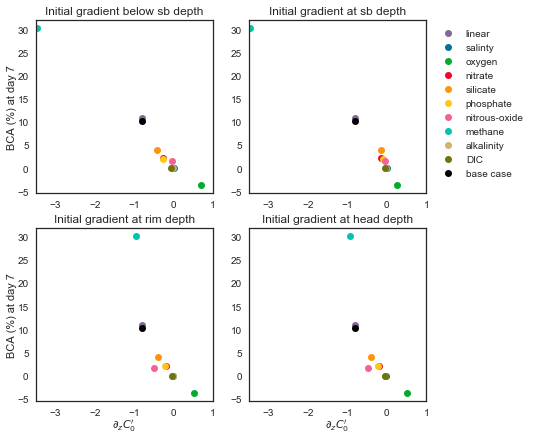

In [22]:
sns.set_context('notebook')

Hs = 147.5 # m, I will plot the non dimensional derivative C'=C/Co, Z'=Z/Hs, 
           # so \partialC'/\partialZ' = Hs/Co \partialC/\partial Z

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,7))

for ii in range(len(BAC_pool)):
    ax1.plot(Hs*inidTrdz_below[ii]/iniConc_rim[ii], BAC_pool[ii]*100, 'o', color=sns.xkcd_rgb[colours[ii]],
             label=tracer_legend[ii])
    ax2.plot(Hs*inidTrdz_sb[ii]/iniConc_rim[ii], BAC_pool[ii]*100, 'o', color=sns.xkcd_rgb[colours[ii]],
             label=tracer_legend[ii])
    ax3.plot(Hs*inidTrdz_rim[ii]/iniConc_rim[ii], BAC_pool[ii]*100, 'o', color=sns.xkcd_rgb[colours[ii]],
             label=tracer_legend[ii])
    ax4.plot(Hs*inidTrdz_head[ii]/iniConc_rim[ii], BAC_pool[ii]*100, 'o', color=sns.xkcd_rgb[colours[ii]],
             label=tracer_legend[ii])

ax1.plot(Hs*record.inidTrdz_below/record.iniConc_rim, base_bca[14]*100,  'o', color='k', label='base case')
ax2.plot(Hs*record.inidTrdz_sb/record.iniConc_rim, base_bca[14]*100, 'o', color='k', label='base case')
ax3.plot(Hs*record.inidTrdz_rim/record.iniConc_rim,base_bca[14]*100,  'o', color='k', label='base case')
ax4.plot(Hs*record.inidTrdz_head/record.iniConc_rim,base_bca[14]*100,  'o', color='k', label='base case')
    
ax1.set_ylabel('BCA (%) at day 7', labelpad=0)
ax3.set_ylabel('BCA (%) at day 7', labelpad=0)

ax3.set_xlabel(r'$\partial_zC_0^{\prime}$', labelpad=0)
ax4.set_xlabel(r'$\partial_zC_0^{\prime}$', labelpad=0)

ax1.set_title('Initial gradient below sb depth')
ax2.set_title('Initial gradient at sb depth')
ax3.set_title('Initial gradient at rim depth')
ax4.set_title('Initial gradient at head depth')

ax1.set_xlim(-3.5,1)
ax2.set_xlim(-3.5,1)
ax3.set_xlim(-3.5,1)
ax4.set_xlim(-3.5,1)

ax1.legend(bbox_to_anchor=(2.8,1))

slope = -8.636, intercept = 0.962, r_value = -0.985, p_value = 0.000, std_err = 0.496


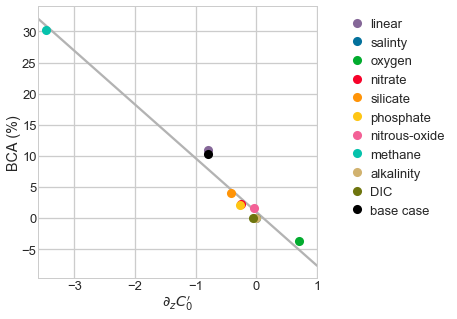

In [23]:
sns.set_context('talk')
sns.set_style('whitegrid')
Hs = 147.5 # m, I will plot the non dimensional derivative C'=C/Co, Z'=Z/Hs, 
           # so \partialC'/\partialZ' = Hs/Co \partialC/\partial Z

fig,ax1 = plt.subplots(1,1,figsize=(5,5))

# Append values of base case
BAC_array = np.append(BAC_pool*100,base_bca[14]*100)
gradient_array = Hs*np.append(inidTrdz_below/iniConc_rim, record.inidTrdz_below/record.iniConc_rim)

colours.append('black')
tracer_legend.append('base case')

# Linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(gradient_array,BAC_array)
print('slope = %1.3f, intercept = %1.3f, r_value = %1.3f, p_value = %1.3f, std_err = %1.3f' %(
        slope, intercept, r_value, p_value, std_err))

# Plot
ax1.plot(np.linspace(-3.6,1,20), (slope*np.linspace(-3.6,1,20))+(np.ones(20)*intercept),'-', color='0.7')

for ii in range(len(BAC_array)):
    ax1.plot(gradient_array[ii],BAC_array[ii], 'o', color=sns.xkcd_rgb[colours[ii]],
             label=tracer_legend[ii])

ax1.set_ylabel('BCA (%)', labelpad=0.5)
ax1.set_xlabel(r'$\partial_zC_0^{\prime}$', labelpad=0)

ax1.tick_params(axis='y', pad=1.5)
ax1.tick_params(axis='x', pad=1.8)

ax1.set_xlim(-3.6,1)

ax1.legend(bbox_to_anchor=(1.5,1), handletextpad=0)

fig.savefig('BCA_vs_GradBelowSB.eps', format='eps', bbox_inches='tight')

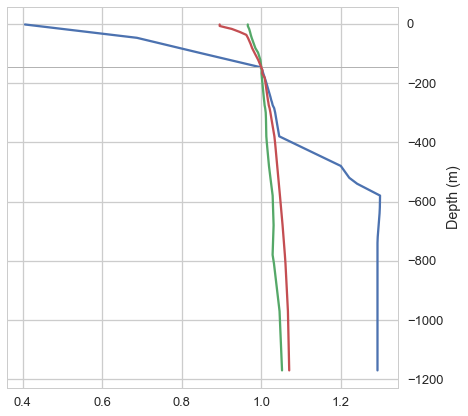

In [32]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
with Dataset(ptracers_file, 'r') as nbl:
    for trac in [ 'Tr07','Tr09', 'Tr10']:
        ax.axhline(Z[29], color='0.7', linewidth=1)
        profile = nbl.variables[trac][0,:,50,180]
        C0 = profile[29]
        ax.plot(profile/C0,Z[:])
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('Depth (m)')
